# Análise - O Oscar na Última Década

## Integrantes:

### João Victor Soares Silva | Mat.: 20210027300
### Marília Gabriela Toscano da Silva | Mat.: 20210067065
### Matheus Victor Alves Braga Maciel | Mat.:

# Introdução

///Texto da introdução e motivação

A motivação inicial foi observar quais as relações existentes entre as notas de avaliação de filmes no site estadunidense Rotten Tomatoes com os dados de indicados e ganhadores do Oscar, para saber se a opnião pública condizia com os resultados da academia.

## Objetivos

### Objetivos Gerais
* Encontrar quais variáveis (ano, gênero, duração, classificação indicativa, etc.) tinham maior relação com os resultados das premiações.
* Entender como as avaliações do público e da crítica afetam as chances de um filme ser ganhador da premiação

### Objetivos Específicos
* Descobrir quais características mais se repetiam entre os filmes vencedores da premiação
* Analisar quais os tipos de filme recebem melhores avaliações do público e da crítica
* Encontrar a melhor maneira de prever as chances de vitória de um filme com base em suas avaliações e suas propriedades

# Dados Usados

Bibliotecas utilizadas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

Dataframes utilizados:

* Dataset do Rotten Tomatoes : Contém informações técnicas sobre os filmes avaliados no site como: título, data original de lançamento, data de lançamento em sites de streaming, tempo de duração, gênero, diretor(es), elenco, roteirista(s), estúdio de cinema e classificação indicativa. Além disso, inclui uma breve sinopse da obra e um consenso geral dos comentários da crítica. Por fim, apresenta as porcentagens de avaliações positivas da audiência e dos críticos, quantidade de avaliações de cada um e algumas variáveis próprias do site; tais como, as classificações de "rotten" para filmes com menos de 60% de avaliações positivas da crítica e "fresh" para os com mais de 60%.

* Dataset do Oscar : Engloba dados de 1927 até 2020 referentes à cerimônia de premiação; como, ano e número do evento, título e ano de exibição dos filmes indicados, nomes dos artistas indicados, categorias de indicação e quais foram os vencedores.

Agora, vamos importar os dataframes:

In [2]:
#Dataframe dos indicados ao Oscar:

oscar = pd.read_csv('BigML_Dataset_5f50a62c2fb31c516d000176.csv')
oscar.head(1)

,year,movie,movie_id,certificate,duration,genre,rate,metascore,synopsis,votes,...,New_York_Film_Critics_Circle_nominated,New_York_Film_Critics_Circle_nominated_categories,Los_Angeles_Film_Critics_Association_won,Los_Angeles_Film_Critics_Association_won_categories,Los_Angeles_Film_Critics_Association_nominated,Los_Angeles_Film_Critics_Association_nominated_categories,release_date.year,release_date.month,release_date.day-of-month,release_date.day-of-week
0,2001,Kate & Leopold,tt0035423,PG-13,118,Comedy|Fantasy|Romance,6.4,44.0,An English Duke from 1876 is inadvertedly drag...,66660,...,0,NaN,0,NaN,0,NaN,2001.0,12.0,25.0,2.0


In [3]:
#Dataframe dos filmes no site Rotten Tomatoes:

rotten = pd.read_csv('rotten_tomatoes_movies.csv')
rotten.head(1)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76


# Pré-Processamento

A seguir, iremos manipular os dataframes usados como base na pesquisa de forma que seja gerado um outro que contenha apenas as informações que serão relevantes para a pesquisa.
Começando pelo dataframe 'oscar':

1. O dataframe possui muitas colunas, para tornar o processamento dos dados mais ágil, iremos limpá-lo e deixar apenas as colunas que serão relevantes à pesquisa:

In [4]:
oscar = oscar[['year', 'movie', 'certificate', 'duration', 'genre', 'rate', 'votes', 'metascore', 'Oscar_Best_Picture_won', 'Oscar_Best_Director_won', 'Oscar_Best_Actor_won', 'Oscar_Best_Actress_won']]
oscar.head()

,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,Oscar_Best_Actor_won,Oscar_Best_Actress_won
0,2001,Kate & Leopold,PG-13,118,Comedy|Fantasy|Romance,6.4,66660,44.0,No,No,No,No
1,2000,Chicken Run,G,84,Animation|Adventure|Comedy,7.0,144475,88.0,No,No,No,No
2,2005,Fantastic Four,PG-13,106,Action|Adventure|Family,5.7,273203,40.0,No,No,No,No
3,2002,Frida,R,123,Biography|Drama|Romance,7.4,63852,61.0,No,No,No,No
4,2001,The Lord of the Rings: The Fellowship of the Ring,PG-13,178,Adventure|Drama|Fantasy,8.8,1286275,92.0,No,No,No,No


2. As linhas contendo valores nulos (NaN) foram descartadas, pois não é interessante algumas análises utilizarem uma amostra de dados maior que outras:

In [5]:
oscar = oscar.dropna()

3. Os filmes que concorreram à edição de 2000 foram descartados, visto que nosso corte temporal é este século:

In [6]:
oscar = oscar [(oscar.year > 2000)]
oscar.reset_index(inplace = True, drop = False)
oscar.head()

,index,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,Oscar_Best_Actor_won,Oscar_Best_Actress_won
0,0,2001,Kate & Leopold,PG-13,118,Comedy|Fantasy|Romance,6.4,66660,44.0,No,No,No,No
1,2,2005,Fantastic Four,PG-13,106,Action|Adventure|Family,5.7,273203,40.0,No,No,No,No
2,3,2002,Frida,R,123,Biography|Drama|Romance,7.4,63852,61.0,No,No,No,No
3,4,2001,The Lord of the Rings: The Fellowship of the Ring,PG-13,178,Adventure|Drama|Fantasy,8.8,1286275,92.0,No,No,No,No
4,6,2002,Resident Evil,R,100,Action|Horror|Sci-Fi,6.7,204545,33.0,No,No,No,No


Agora vamos manipular o dataframe 'rotten':

1. Aqui, vamos filtrar as colunas que utilizaremos:

In [7]:
rotten = rotten[['movie_title', 'tomatometer_status', 'tomatometer_rating', 'audience_status', 'audience_rating']]
rotten.head(1)

,movie_title,tomatometer_status,tomatometer_rating,audience_status,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,Rotten,49.0,Spilled,53.0


2. Por fim, vamos retirar as linhas que possuem valores vazios (NaN):

In [8]:
rotten = rotten.dropna()

Com isso feito, agora, vamos associar os filmes de um dataframe ao outro, através dos seus nomes:

In [9]:
#Renomeando a coluna de nomes para que fiquem idênticas:
rotten.rename(columns = {'movie_title':'movie'}, inplace = True)

#Juntando os dataframes:
df_final = pd.merge(oscar, rotten, how = 'inner', on = 'movie')
df_final.head(1)

,index,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,Oscar_Best_Actor_won,Oscar_Best_Actress_won,tomatometer_status,tomatometer_rating,audience_status,audience_rating
0,0,2001,Kate & Leopold,PG-13,118,Comedy|Fantasy|Romance,6.4,66660,44.0,No,No,No,No,Rotten,50.0,Upright,62.0


Para evitar distorção nos dados, vamos verificar quantos filmes foram perdidos nessa associação entre os dataframes:

In [10]:
# Verificando quantas linhas foram perdidas no merge:
print(f'Número de linhas do dataframe final: {df_final.shape[0]}')
print(f'Número de linhas perdidas no merge: {oscar.shape[0] - df_final.shape[0]}')
print(f'Percentual de perda de dados: {((oscar.shape[0] - df_final.shape[0]) * 100) / df_final.shape[0]:.2f}%')

Número de linhas do dataframe final: 1062
Número de linhas perdidas no merge: 27
Percentual de perda de dados: 2.54%


O número de filmes descartados pela associação não foi muito grande, contudo, as informações ficarão registradas para evitar dúvidas sobre distorções. Assim, acabamos nosso pré-processamento.

# Quais as características mais frequentes entre os filmes indicados à premiação?

Para responder essa pergunta, iremos analisar nosso dataframe final e encontrar quais os dados mais comuns nas seguintes colunas:
* 'certificate';
* 'duration';
* 'genre';
* 'rate';
* 'metascore';
* 'tomatometer_status';
* 'tomatometer_rating';
* 'audience_status';
* 'audience_rating'.

Classificação indicativa mais comum:

[Text(0.5, 0, 'Certificados'), Text(0, 0.5, 'Nº de ocorrências')]

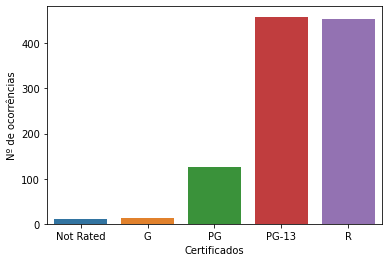

In [11]:
#Contando a frequência de cada classificação:
count_cert = df_final.groupby(['certificate']).size()

#Juntando classificações iguais, mas com termos distintos:
#Unrated e Not Rated:
count_cert['Not Rated'] += count_cert['Unrated']
del(count_cert['Unrated'])

#TV-MA e R:
count_cert['R'] += count_cert['TV-MA']
del(count_cert['TV-MA'])

#Organizando:
count_cert = count_cert.reindex(index = ['Not Rated', 'G', 'PG', 'PG-13', 'R'])

#Visualização:
graph_cert = sns.barplot(x = count_cert.index, y = count_cert.values)
graph_cert.set(xlabel = 'Certificados', ylabel = 'Nº de ocorrências')

Podemos ver que, quanto maior a classificação indicativa, maior a frequência de indicados. Em ordem, temos:

In [12]:
count_cert = count_cert.sort_values(ascending = False)

count_cert

certificate
PG-13        459
R            455
PG           125
G             13
Not Rated     10
dtype: int64

Duração mais comum:

* Decidimos categorizar as durações de acordo com um intervalo, para agrupar as que têm durações semelhantes, assim:

[Text(0.5, 0, 'Duração'), Text(0, 0.5, 'Nº de ocorrências')]

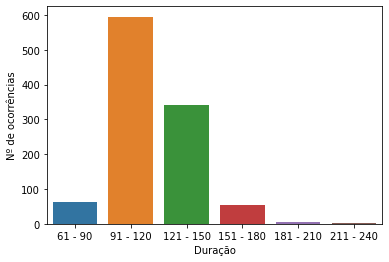

In [13]:
#A função a seguir devolve o intervalo em que o número está. A generalizamos para uso futuro:
def n_break (n, start, end, mod, scale_cem = True):
    break_start = start
    break_end = end

    if scale_cem:
        while True:
            if (break_start <= n <= break_end):
                return f'{break_start} - {break_end}'
            else:
                break_start = break_end + 1
                break_end += mod
    
    else:
        while True:
            if (break_start <= n <= break_end):
                return f'{break_start} - {break_end}'
            else:
                break_start = break_end + 0.1
                break_end += mod

#Adicionando a coluna duration_break dos intervalos das durações:
count_dur = df_final
count_dur['duration_break'] = count_dur['duration'].apply(n_break, args = (1, 30, 30))

#Contando a frequência de cada intervalo:
count_dur = count_dur.groupby(['duration_break']).size()

#Organizando:
count_dur = count_dur.reindex(index = ['61 - 90', '91 - 120', '121 - 150', '151 - 180', '181 - 210', '211 - 240'])

#Visualização:
graph_cert = sns.barplot(x = count_dur.index, y = count_dur.values)
graph_cert.set(xlabel = 'Duração', ylabel = 'Nº de ocorrências')


Em ordem:

In [14]:
count_dur = count_dur.sort_values(ascending = False)

count_dur

duration_break
91 - 120     595
121 - 150    342
61 - 90       64
151 - 180     54
181 - 210      6
211 - 240      1
dtype: int64

Gênero mais comum:

In [15]:
#Função para criar o dicionário com os gêneros e suas ocorrências:
def str_count (str, dict):
    dicio = dict

    if ('|' in str):
        str = str.split('|')

        for i in range (len(str)):
            if (str[i] in dicio.keys()):
                dicio[str[i]] += 1
        
            else:
                dicio[str[i]] = 1

    else:
        if (str in dicio.keys()):
            dicio[str] += 1
        
        else:
            dicio[str] = 1
    
    return dicio

#Criando o dicionário:
dicio_gen = {}

for i in range(len(df_final.index)):
    dicio_gen = str_count(df_final['genre'].iloc[i], dicio_gen)

count_gen = pd.DataFrame(list(dicio_gen.items()), columns = ['genre', 'occurrence'])

#Organizando:
count_gen = count_gen.sort_values(['occurrence'], ascending = False)

count_gen




,genre,occurrence
7,Drama,599
4,Adventure,297
3,Action,290
0,Comedy,281
2,Romance,186
11,Crime,165
12,Thriller,142
9,Sci-Fi,116
6,Biography,113
1,Fantasy,111


Avaliação do IMDb mais comum:

* Assim como nas durações, agruparemos em intervalos as notas semelhantes:

In [16]:
#def inteirar (n):
    #return int(n)

#Adicionando a coluna rate_break dos intervalos das notas:
#count_rate = df_final
#count_rate = count_rate['rate'].apply(inteirar)

# get names of indexes for which
# column Age has value 21
#index_names = count_rate[count_rate['rate'] < 0 ].index
  
# drop these row indexes
# from dataFrame
#count_rate.drop(index_names, inplace = True)

#count_rate['rate_break'] = count_rate['rate'].apply(n_break, args = (0, 1, 1, False))

#Contando a frequência de cada intervalo:
#count_rate = count_rate.groupby(['rate_break']).size()

#count_rate

#Organizando:
#count_rate = count_rate.reindex(index = ['61 - 90', '91 - 120', '121 - 150', '151 - 180', '181 - 210', '211 - 240'])

#Visualização:
#graph_cert = sns.barplot(x = count_rate.index, y = count_rate.values)
#graph_cert.set(xlabel = 'Duração', ylabel = 'Nº de ocorrências')


Metascore mais comum:

[Text(0.5, 0, 'Metascore'), Text(0, 0.5, 'Nº de ocorrências')]

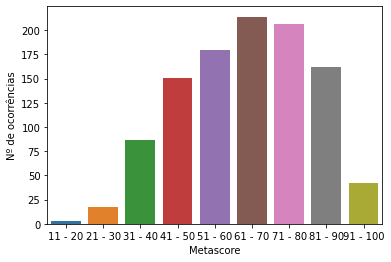

In [17]:
#Adicionando a coluna meta_break dos intervalos das notas:
count_meta = df_final
count_meta['meta_break'] = count_meta['metascore'].apply(n_break, args = (0, 10, 10))

#Contando a frequência de cada intervalo:
count_meta = count_meta.groupby(['meta_break']).size()

#Visualização:
graph_meta = sns.barplot(x = count_meta.index, y = count_meta.values)
graph_meta.set(xlabel = 'Metascore', ylabel = 'Nº de ocorrências')

Em ordem:

In [18]:
count_meta = count_meta.sort_values(ascending = False)

count_meta

meta_break
61 - 70     214
71 - 80     206
51 - 60     180
81 - 90     162
41 - 50     151
31 - 40      87
91 - 100     42
21 - 30      17
11 - 20       3
dtype: int64

Status do Tomatometer mais comum:

[Text(0.5, 0, 'Status'), Text(0, 0.5, 'Nº de ocorrências')]

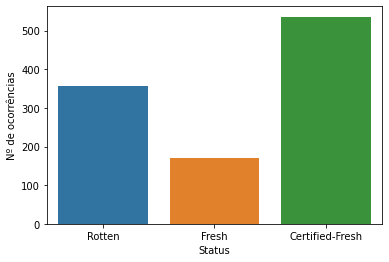

In [19]:
#Contando a frequência de cada status:
count_tomatometer = df_final.groupby(['tomatometer_status']).size()

count_tomatometer

#Organizando:
count_tomatometer = count_tomatometer.reindex(index = ['Rotten', 'Fresh', 'Certified-Fresh'])

#Visualização:
graph_tomatometer = sns.barplot(x = count_tomatometer.index, y = count_tomatometer.values)
graph_tomatometer.set(xlabel = 'Status', ylabel = 'Nº de ocorrências')

Em ordem:

In [20]:
count_tomatometer = count_tomatometer.sort_values(ascending = False)

count_tomatometer

tomatometer_status
Certified-Fresh    536
Rotten             356
Fresh              170
dtype: int64

O Tomatometer mais comum:

[Text(0.5, 0, 'Nota'), Text(0, 0.5, 'Nº de ocorrências')]

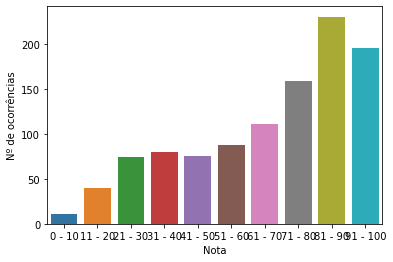

In [21]:
#Adicionando a coluna tomatometer_break dos intervalos das notas:
count_tomatometer_rating = df_final
count_tomatometer_rating['tomatometer_break'] = count_tomatometer_rating['tomatometer_rating'].apply(n_break, args = (0, 10, 10))

#Contando a frequência de cada intervalo:
count_tomatometer_rating = count_tomatometer_rating.groupby(['tomatometer_break']).size()

#Visualização:
graph_cert = sns.barplot(x = count_tomatometer_rating.index, y = count_tomatometer_rating.values)
graph_cert.set(xlabel = 'Nota', ylabel = 'Nº de ocorrências')



O status da audiência mais comum:

[Text(0.5, 0, 'Status'), Text(0, 0.5, 'Nº de ocorrências')]

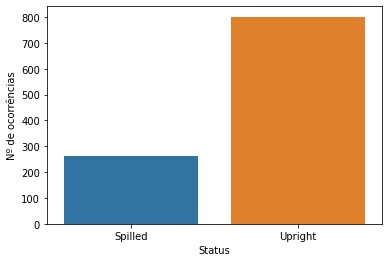

In [22]:
#Contando a frequência de cada status:
count_audience = df_final.groupby(['audience_status']).size()

#Visualização:
graph_audience = sns.barplot(x = count_audience.index, y = count_audience.values)
graph_audience.set(xlabel = 'Status', ylabel = 'Nº de ocorrências')

Em ordem:

In [23]:
count_audience = count_audience.sort_values(ascending = False)

count_audience

audience_status
Upright    801
Spilled    261
dtype: int64

A nota do público mais comum:

[Text(0.5, 0, 'Nota'), Text(0, 0.5, 'Nº de ocorrências')]

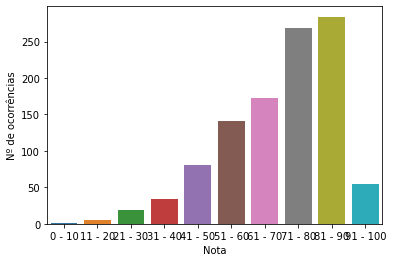

In [24]:
#Adicionando a coluna audience_break dos intervalos das notas:
count_audience_rating = df_final
count_audience_rating['audience_break'] = count_audience_rating['audience_rating'].apply(n_break, args = (0, 10, 10))

#Contando a frequência de cada intervalo:
count_audience_rating = count_audience_rating.groupby(['audience_break']).size()

#Visualização:
graph_audience = sns.barplot(x = count_audience_rating.index, y = count_audience_rating.values)
graph_audience.set(xlabel = 'Nota', ylabel = 'Nº de ocorrências')

Em ordem:

In [25]:
count_audience_rating = count_audience_rating.sort_values(ascending = False)

count_audience_rating

audience_break
81 - 90     284
71 - 80     269
61 - 70     173
51 - 60     141
41 - 50      81
91 - 100     55
31 - 40      34
21 - 30      19
11 - 20       5
0 - 10        1
dtype: int64

Conclusão:

In [26]:
print (f"Classificação mais frequente: {count_cert.index[count_cert.argmax()]} | {count_cert[count_cert.argmax()]}.")
print (f"Duração mais frequente: {count_dur.index[count_dur.argmax()]} | {count_dur[count_dur.argmax()]}.")

Classificação mais frequente: PG-13 | 459.
Duração mais frequente: 91 - 120 | 595.


# Dentre os indicados, qual o perfil dos filmes que foram melhor aceitos pelo público e pela crítica?

Para responder essa pergunta, primeiro é importante que encontremos um padrão para os filmes que consideraremos como bem recebidos nos parâmetros estudados. Decidimos por, então:
* Utilizar o "Certified Fresh" para categorizar um filme como bem recebido no Tomatometer:

In [69]:
df_cut = df_final [(df_final.tomatometer_status == 'Certified-Fresh')]
df_cut.reset_index(inplace = True, drop = False)
df_cut.drop(["level_0", "index"], axis = 1, inplace = True)
df_cut.head()

C:\Users\Joaov\AppData\Local\Temp\ipykernel_1756\255319205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut.drop(["level_0", "index"], axis = 1, inplace = True)


,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,Oscar_Best_Actor_won,Oscar_Best_Actress_won,tomatometer_status,tomatometer_rating,audience_status,audience_rating,duration_break,meta_break,tomatometer_break,audience_break
0,2002,Frida,R,123,Biography|Drama|Romance,7.4,63852,61.0,No,No,No,No,Certified-Fresh,75.0,Upright,85.0,121 - 150,61 - 70,71 - 80,81 - 90
1,2001,The Lord of the Rings: The Fellowship of the Ring,PG-13,178,Adventure|Drama|Fantasy,8.8,1286275,92.0,No,No,No,No,Certified-Fresh,91.0,Upright,95.0,151 - 180,91 - 100,91 - 100,91 - 100
2,2005,Star Wars: Episode III - Revenge of the Sith,PG-13,140,Action|Adventure|Fantasy,7.6,543318,68.0,No,No,No,No,Certified-Fresh,80.0,Upright,66.0,121 - 150,61 - 70,71 - 80,61 - 70
3,2001,Shrek,PG,90,Animation|Adventure|Comedy,7.9,483447,84.0,No,No,No,No,Certified-Fresh,88.0,Upright,90.0,61 - 90,81 - 90,81 - 90,81 - 90
4,2001,Planet of the Apes,PG-13,119,Action|Adventure|Sci-Fi,5.7,181213,50.0,No,No,No,No,Certified-Fresh,87.0,Upright,87.0,91 - 120,41 - 50,81 - 90,81 - 90


* Utilizar o "Fresh" para categorizar um filme como bem recebido na nota dos usuários do Rotten Tomatoes:

In [70]:
df_cut = df_cut [(df_final.audience_status == 'Upright')]
df_cut.reset_index(inplace = True, drop = False)
df_cut.drop(["index"], axis = 1, inplace = True)
df_cut.head()

C:\Users\Joaov\AppData\Local\Temp\ipykernel_1756\238729717.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut = df_cut [(df_final.audience_status == 'Upright')]
C:\Users\Joaov\AppData\Local\Temp\ipykernel_1756\238729717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut.drop(["index"], axis = 1, inplace = True)


,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,Oscar_Best_Actor_won,Oscar_Best_Actress_won,tomatometer_status,tomatometer_rating,audience_status,audience_rating,duration_break,meta_break,tomatometer_break,audience_break
0,2002,Frida,R,123,Biography|Drama|Romance,7.4,63852,61.0,No,No,No,No,Certified-Fresh,75.0,Upright,85.0,121 - 150,61 - 70,71 - 80,81 - 90
1,2001,Shrek,PG,90,Animation|Adventure|Comedy,7.9,483447,84.0,No,No,No,No,Certified-Fresh,88.0,Upright,90.0,61 - 90,81 - 90,81 - 90,81 - 90
2,2001,Planet of the Apes,PG-13,119,Action|Adventure|Sci-Fi,5.7,181213,50.0,No,No,No,No,Certified-Fresh,87.0,Upright,87.0,91 - 120,41 - 50,81 - 90,81 - 90
3,2002,Spider-Man,PG-13,121,Action|Adventure,7.3,561251,73.0,No,No,No,No,Certified-Fresh,90.0,Upright,67.0,121 - 150,71 - 80,81 - 90,61 - 70
4,2001,Mulholland Drive,R,147,Drama|Mystery|Thriller,8.0,247207,81.0,No,No,No,No,Certified-Fresh,83.0,Upright,87.0,121 - 150,81 - 90,81 - 90,81 - 90


* A partir daqui, temos um dataframe que contém apenas os filmes mais bem avaliados do site do Rotten. Agora, vamos usar esse dataframe para agrupar esses dados conforme as notas do IMDb e do Metacritic.
Usaremos o método do cotovelo para determinar qual o melhor número de grupos que podemos formar:

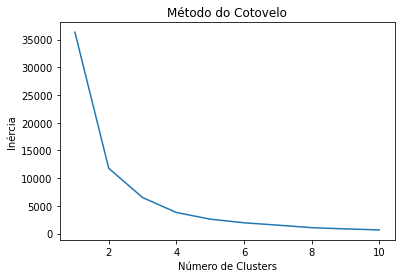

In [71]:
#Dataframe auxiliar para plotar o gráfico:
aux = df_cut.reindex(columns = ['rate', 'metascore'])

#Aplicando o método:
inercia = []

for i in range (1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10)
    kmeans.fit(aux)
    inercia.append(kmeans.inertia_)

plt.plot(range(1, 11), inercia)
plt.title("Método do Cotovelo")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.show()

O valor 2 mostra ser o ponto de "cotovelo" do gráfico, assim, faremos 2 grupos:

In [72]:
#Aplicando:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10)
clusters = kmeans.fit_predict(aux)

#Dataframe com o cluster:
aux['cluster'] = clusters
df_cut['cluster'] = clusters
df_cut.head()

,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,...,Oscar_Best_Actress_won,tomatometer_status,tomatometer_rating,audience_status,audience_rating,duration_break,meta_break,tomatometer_break,audience_break,cluster
0,2002,Frida,R,123,Biography|Drama|Romance,7.4,63852,61.0,No,No,...,No,Certified-Fresh,75.0,Upright,85.0,121 - 150,61 - 70,71 - 80,81 - 90,0
1,2001,Shrek,PG,90,Animation|Adventure|Comedy,7.9,483447,84.0,No,No,...,No,Certified-Fresh,88.0,Upright,90.0,61 - 90,81 - 90,81 - 90,81 - 90,1
2,2001,Planet of the Apes,PG-13,119,Action|Adventure|Sci-Fi,5.7,181213,50.0,No,No,...,No,Certified-Fresh,87.0,Upright,87.0,91 - 120,41 - 50,81 - 90,81 - 90,0
3,2002,Spider-Man,PG-13,121,Action|Adventure,7.3,561251,73.0,No,No,...,No,Certified-Fresh,90.0,Upright,67.0,121 - 150,71 - 80,81 - 90,61 - 70,0
4,2001,Mulholland Drive,R,147,Drama|Mystery|Thriller,8.0,247207,81.0,No,No,...,No,Certified-Fresh,83.0,Upright,87.0,121 - 150,81 - 90,81 - 90,81 - 90,1


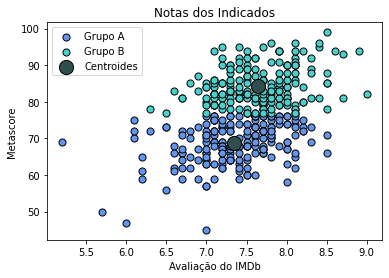

In [73]:
#Plot do gráfico:
x = aux.to_numpy()

plt.scatter(
    x[clusters == 0, 0], x[clusters == 0, 1],
    s=50, c='cornflowerblue',
    edgecolor='black',
    label='Grupo A'
)

plt.scatter(
    x[clusters == 1, 0], x[clusters == 1, 1],
    s=50, c='mediumturquoise',
    edgecolor='black',
    label='Grupo B'
)

plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=200, c='darkslategrey', edgecolor='black',
    label='Centroides'
)

plt.title("Notas dos Indicados")
plt.xlabel("Avaliação do IMDb")
plt.ylabel("Metascore")

plt.legend()
plt.show()

O grupo B possui notas mais favoráveis em ambos os parâmetros, então utilizaremos ele para a análise:

In [76]:
#Assumindo somente os filmes do grupo B:
df_cut = df_cut [(df_cut.cluster == 1)]
df_cut.reset_index(inplace = True, drop = False)
df_cut.drop(["index"], axis = 1, inplace = True)

print(f'Número de filmes que restaram: {df_cut.shape[0]}.')

Número de filmes que restaram: 200.


Agora, traçaremos o perfil desses filmes:
///repetir processo da pergunta 1

# Qual o melhor parâmetro, entre os estudados, para determinar as chances de vitória de um filme na categoria de Melhor Filme (Best Picture)?

Para este objetivo, iremos filtrar os vencedores da categoria contidos no dataframe e analisá-los sobre os parâmetros avaliativos para determinar:
* Qual parâmetro deu a maior nota a cada vencedor? Utilizaremos um ranking para contabilizar todos os vencedores;
* Qual a média dos vencedores em cada parâmetro?

In [97]:
#Pegando os vencedores da categoria no dataframe:

df_cut = df_final [(df_final.Oscar_Best_Picture_won == 'Yes')]
df_cut.reset_index(inplace = True, drop = False)
df_cut.drop(["level_0", "index"], axis = 1, inplace = True)
#print(df_cut.shape[0])
df_cut.head()

C:\Users\Joaov\AppData\Local\Temp\ipykernel_1756\3048045318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut.drop(["level_0", "index"], axis = 1, inplace = True)


,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,Oscar_Best_Actor_won,Oscar_Best_Actress_won,tomatometer_status,tomatometer_rating,audience_status,audience_rating,duration_break,meta_break,tomatometer_break,audience_break
0,2003,The Lord of the Rings: The Return of the King,PG-13,201,Adventure|Drama|Fantasy,8.9,1264277,94.0,Yes,Yes,No,No,Certified-Fresh,93.0,Upright,86.0,181 - 210,91 - 100,91 - 100,81 - 90
1,2001,A Beautiful Mind,PG-13,135,Biography|Drama,8.2,640458,72.0,Yes,Yes,No,No,Certified-Fresh,74.0,Upright,93.0,121 - 150,71 - 80,71 - 80,91 - 100
2,2002,Chicago,PG-13,113,Comedy|Crime|Musical,7.2,176942,82.0,Yes,No,No,No,Certified-Fresh,86.0,Upright,83.0,91 - 120,81 - 90,81 - 90,81 - 90
3,2004,Crash,R,112,Crime|Drama|Thriller,7.8,368775,69.0,Yes,No,No,No,Certified-Fresh,74.0,Upright,88.0,91 - 120,61 - 70,71 - 80,81 - 90
4,2004,Million Dollar Baby,PG-13,132,Drama|Sport,8.1,501680,86.0,Yes,Yes,No,Yes,Certified-Fresh,91.0,Upright,90.0,121 - 150,81 - 90,91 - 100,81 - 90


In [98]:
def zero_a_cem (a):
    return round(a * 10, 1)

def compare (a, b, c, d):
    if (a > b and a > c and a > d):
        return 'Tomatometer'
    elif (b > a and b > c and b > d):
        return 'Audience Rating - RT'
    elif (c > a and c > b and c > d):
        return 'Metascore'
    elif (d > a and d > b and d > c):
        return 'IMDb Rate'
    else:
        return 'Draw'

df_cut['rate'] = df_cut['rate'].apply(zero_a_cem)
df_cut['indicator'] = df_cut.apply(lambda x: compare(x["tomatometer_rating"], x["audience_rating"], x['metascore'], x['rate']), axis = 1)
df_cut


C:\Users\Joaov\AppData\Local\Temp\ipykernel_1756\350572264.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['rate'] = df_cut['rate'].apply(zero_a_cem)
C:\Users\Joaov\AppData\Local\Temp\ipykernel_1756\350572264.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['indicator'] = df_cut.apply(lambda x: compare(x["tomatometer_rating"], x["audience_rating"], x['metascore'], x['rate']), axis = 1)


,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,...,Oscar_Best_Actress_won,tomatometer_status,tomatometer_rating,audience_status,audience_rating,duration_break,meta_break,tomatometer_break,audience_break,indicator
0,2003,The Lord of the Rings: The Return of the King,PG-13,201,Adventure|Drama|Fantasy,89.0,1264277,94.0,Yes,Yes,...,No,Certified-Fresh,93.0,Upright,86.0,181 - 210,91 - 100,91 - 100,81 - 90,Metascore
1,2001,A Beautiful Mind,PG-13,135,Biography|Drama,82.0,640458,72.0,Yes,Yes,...,No,Certified-Fresh,74.0,Upright,93.0,121 - 150,71 - 80,71 - 80,91 - 100,Audience Rating - RT
2,2002,Chicago,PG-13,113,Comedy|Crime|Musical,72.0,176942,82.0,Yes,No,...,No,Certified-Fresh,86.0,Upright,83.0,91 - 120,81 - 90,81 - 90,81 - 90,Tomatometer
3,2004,Crash,R,112,Crime|Drama|Thriller,78.0,368775,69.0,Yes,No,...,No,Certified-Fresh,74.0,Upright,88.0,91 - 120,61 - 70,71 - 80,81 - 90,Audience Rating - RT
4,2004,Million Dollar Baby,PG-13,132,Drama|Sport,81.0,501680,86.0,Yes,Yes,...,Yes,Certified-Fresh,91.0,Upright,90.0,121 - 150,81 - 90,91 - 100,81 - 90,Tomatometer
5,2006,The Departed,R,151,Crime|Drama|Thriller,85.0,910945,85.0,Yes,Yes,...,No,Certified-Fresh,91.0,Upright,94.0,151 - 180,81 - 90,91 - 100,91 - 100,Audience Rating - RT
6,2007,No Country for Old Men,R,122,Crime|Drama|Thriller,81.0,640561,91.0,Yes,Yes,...,No,Certified-Fresh,93.0,Upright,86.0,121 - 150,91 - 100,91 - 100,81 - 90,Tomatometer
7,2008,The Hurt Locker,R,131,Drama|History|Thriller,76.0,343364,94.0,Yes,Yes,...,No,Certified-Fresh,97.0,Upright,84.0,121 - 150,91 - 100,91 - 100,81 - 90,Tomatometer
8,2008,Slumdog Millionaire,R,120,Drama,80.0,661819,86.0,Yes,Yes,...,No,Certified-Fresh,91.0,Upright,90.0,91 - 120,81 - 90,91 - 100,81 - 90,Tomatometer
9,2012,Argo,R,120,Biography|Drama|History,77.0,468444,86.0,Yes,No,...,No,Certified-Fresh,96.0,Upright,90.0,91 - 120,81 - 90,91 - 100,81 - 90,Tomatometer


Agrupando e criando o ranking:

In [100]:
indicator_count = df_cut.groupby(['indicator']).size()
indicator_count = indicator_count.sort_values(ascending = False)

indicator_count

indicator
Tomatometer             9
Metascore               4
Audience Rating - RT    3
dtype: int64

Comparando com as médias:

In [101]:
tomatometer_mean = df_cut[['tomatometer_rating']].mean()
audience_mean = df_cut[['audience_rating']].mean()
metascore_mean = df_cut[['metascore']].mean()
imdb_mean = df_cut[['rate']].mean()

print(tomatometer_mean)
print(audience_mean)
print(metascore_mean)
print(imdb_mean)

tomatometer_rating    89.0625
dtype: float64
audience_rating    87.0
dtype: float64
metascore    88.0625
dtype: float64
rate    80.8125
dtype: float64


# Conclusão

///Resumir as respostas, destacar sua importância, apontar limitações, trabalhos futuros e melhorias.